In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import utilities.helpers as hp

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

import pyLDAvis.sklearn

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


# Unknown Homeland cases topic modelling:

# Import data set:

In [2]:
pd.options.mode.chained_assignment = None

df_full = hp.import_dataset(encoding='utf-8')
df_full.shape


(9635, 5)

# Dataset preprocessing:

Cases of Unknown Homeland (Ukendt hjemland) are kept.

Below we see the shape and head of the dataset.

In [3]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_UH[['text']]

df["text"] = df["text"].astype("string")

df.shape

(192, 1)

In [4]:

df.head()

text
287           Nævnet stadfæstede i november 2021 Udl...
515           Nævnet stadfæstede i juni 2021 Udlændi...
551           Nævnet stadfæstede i juni 2021 Udlændi...
989           Nævnet stadfæstede i december 2020 Udl...
1379          Nævnet hjemviste i juni 2020 Udlænding...

Check for potential duplicates and drop them:

In [5]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

text
1421          Nævnet stadfæstede i maj 2020 Udlændin...
1440          Nævnet stadfæstede i maj 2020 Udlændin...
4102          Nævnet stadfæstede i januar 2018 Udlæn...
4103          Nævnet stadfæstede i januar 2018 Udlæn...
4157          Nævnet stadfæstede i januar 2018 Udlæn...
4160          Nævnet stadfæstede i januar 2018 Udlæn...

New shape for dataset after droping duplicate entries.

In [6]:
# Drop duplicates from original dataframe:
df = df.drop_duplicates()

# Check shape again:
df.shape

(189, 1)

# Use a pipeline to pre-process the texts:

The pipeline consists of the following steps:

- Lowercase all characters
- Drop numbers
- Remove punctuation
- Remove stopwords. The list of stopwords can be found [here](https://github.com/jethronap/AsylumData_KU/blob/main/misc/stopwords_dk.txt).
- Single letter words are dropped, too.
- Tokenization
- Lemmatization. The process during which all words are turned into its roots. 

Steps can be added or removed from the pipeline.

In [7]:
pipeline = [str.lower, hp.drop_numbers, hp.remove_punctuation, hp.remove_stopwords, hp.drop_single_letter_words,
            hp.tokenize, hp.lemmatize]


In [8]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(hp.process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [9]:
df.head()

text  \
287           Nævnet stadfæstede i november 2021 Udl...   
515           Nævnet stadfæstede i juni 2021 Udlændi...   
551           Nævnet stadfæstede i juni 2021 Udlændi...   
989           Nævnet stadfæstede i december 2020 Udl...   
1379          Nævnet hjemviste i juni 2020 Udlænding...   

                                                 tokens  num_tokens  
287   [stadfæste, udlændingestyrels, afgørelse, vedr...         311  
515   [stadfæste, udlændingestyrels, afgørelse, vedr...         209  
551   [stadfæste, udlændingestyrels, afgørelse, vedr...         303  
989   [stadfæste, udlændingestyrels, afgørelse, vedr...         177  
1379  [hjemvise, udlændingestyrels, afgørelse, vedrø...         309

# Analysis:

In [10]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

## Topic Modelling:

In [11]:
# Use tf (raw term count) features for LDA.
count_text_vectorizer = CountVectorizer(min_df=2, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['tokens_joined'])

# Use tf-idf features for NMF and SVD
tfidf_text_vectorizer = TfidfVectorizer(min_df=2, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['tokens_joined'])

### Latent Dirichlet Allocation (LDA):

In [12]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

best_num_LDA = float('NaN')
best_score_LDA = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create LDA model with i topics
    LDA_text_model = LatentDirichletAllocation(n_components=i, random_state=42)
    W_LDA_text_matrix = LDA_text_model.fit_transform(count_text_vectors)
    H_LDA_text_matrix = LDA_text_model.components_

    # Obtain the coherence score
    coherence_model_LDA = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_LDA_text_matrix, 
                        dtm=W_LDA_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_LDA = np.around(coherence_model_LDA, 2)
    for score in coherence_score_LDA:
        if score > best_score_LDA:
            best_num_LDA = i
            best_score_LDA = score

print(f'The coherence score for LDA ({best_score_LDA}) is highest with {best_num_LDA} topics.')

The coherence score for LDA (0.75) is highest with 10 topics.


Build the model with the best number of topics and see them:

In [13]:
LDA_model = LatentDirichletAllocation(n_components=best_num_LDA, random_state=42)
W_LDA_model_matrix = LDA_model.fit_transform(count_text_vectors)
H_LDA_model_matrix = LDA_model.components_

In [14]:
hp.display_topics(LDA_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 dag (1.48)
 deltage (1.42)
 tage (1.41)
 demonstration (1.38)
 side (1.34)

Topic 01
 demonstration (2.71)
 deltage (1.81)
 kvindelig (1.62)
 bidoon (1.61)
 dag (1.47)

Topic 02
 eritrea (3.29)
 år (1.51)
 sudan (1.50)
 føde (0.99)
 tale (0.95)

Topic 03
 mor (1.60)
 bopæl (1.33)
 gang (1.02)
 bidoon (0.85)
 bo (0.81)

Topic 04
 divergere (2.15)
 udlænding (1.78)
 følge (1.55)
 bror (1.52)
 bidoon (1.46)

Topic 05
 kvindelig (2.25)
 demonstration (2.04)
 oplysnings (1.62)
 videre (1.52)
 bopæl (1.47)

Topic 06
 klager (4.42)
 opholdstilladelse (1.72)
 oplysning (1.20)
 danmark (1.15)
 navn (1.09)

Topic 07
 demonstration (2.27)
 bidoon (1.55)
 udsætte (1.22)
 deltage (1.18)
 overgreb (1.02)

Topic 08
 ægtefælle (6.33)
 bo (1.66)
 nærmere (1.47)
 statsborgerskab (1.46)
 angive (1.38)

Topic 09
 slå (1.39)
 ihjel (1.10)
 alshabaab (1.08)
 divergere (0.99)
 udlændingestyrelse (0.99)


Visualise the topics produced by LDA:

In [15]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

LDA_display = pyLDAvis.sklearn.prepare(LDA_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(LDA_display)

/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [16]:
pyLDAvis.save_html(LDA_display, 'LDA_UH.html')

Each bubble in the plot represents a topic. The size of the bubble represents the proportion of cases that contain the topic, with a larger bubble corresponding to a higher proportion. 

The distance between the bubbles represents the similarity between the topics; the shorter the distance, the more similar the topics.

The bars in the bar chart represent the term frequency for each of the words. The blue bars show the overall term frequency in the collection of documents, whereas the red bars show the term frequency for the selected topic.

### Non-Negative Matrix Factorization:

In [17]:
warnings.filterwarnings("ignore", category=FutureWarning)

best_num_NMF = float('NaN')
best_score_NMF = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create NMF model with i topics
    NMF_text_model = NMF(n_components=i, random_state=42)
    W_NMF_text_matrix = NMF_text_model.fit_transform(tfidf_text_vectors)
    H_NMF_text_matrix = NMF_text_model.components_

    # Obtain the coherence score
    coherence_model_NMF = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_NMF_text_matrix, 
                        dtm=W_NMF_text_matrix, 
                        vocab=np.array([x for x in tfidf_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_NMF = np.around(coherence_model_NMF, 2)
    for score in coherence_score_NMF:
        if score > best_score_NMF:
            best_num_NMF = i
            best_score_NMF = score

print(f'The coherence score for NMF ({best_score_NMF}) is highest with {best_num_NMF} topics.')

The coherence score for NMF (0.74) is highest with 4 topics.


Build the model with the best number of topics and see them:

In [18]:
NMF_model = NMF(n_components=best_num_NMF, random_state=42)
W_NMF_model_matrix = NMF_model.fit_transform(tfidf_text_vectors)
H_NMF_model_matrix = NMF_model.components_

The numbers inside the parentheses are the percentages with which the words contribute to the topics.

In [19]:
hp.display_topics(NMF_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
 demonstration (1.20)
 deltage (0.82)
 bidoon (0.81)
 dag (0.58)
 bopæl (0.53)

Topic 01
 klager (13.42)
 klagere (1.77)
 opholdstilladelse (1.51)
 nr (1.14)
 svig (1.04)

Topic 02
 kvindelig (2.07)
 oplysnings (1.43)
 videre (1.20)
 demonstration (1.11)
 motivsamta (1.08)

Topic 03
 eritrea (5.94)
 sudan (2.68)
 eritreisk (1.54)
 etiopien (1.23)
 tigrinya (1.08)


Visualise the topics produced by NMF:

In [20]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


NMF_display = pyLDAvis.sklearn.prepare(NMF_model, tfidf_text_vectors, tfidf_text_vectorizer, sort_topics=False)

pyLDAvis.display(NMF_display)

In [21]:
pyLDAvis.save_html(NMF_display, 'NMF_UH.html')

### Latent Semantic Analysis/Indexing:

In [22]:
warnings.filterwarnings("ignore", category=FutureWarning)

best_num_SVD = float('NaN')
best_score_SVD = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create SVD model with i topics
    SVD_text_model = TruncatedSVD(n_components=i, random_state=42)
    W_SVD_text_matrix = SVD_text_model.fit_transform(tfidf_text_vectors)
    H_SVD_text_matrix = SVD_text_model.components_

    # Obtain the coherence score
    coherence_model_SVD = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_SVD_text_matrix, 
                        dtm=W_SVD_text_matrix, 
                        vocab=np.array([x for x in tfidf_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score_SVD = np.around(coherence_model_SVD, 2)
    for score in coherence_score_SVD:
        if score > best_score_SVD:
            best_num_SVD = i
            best_score_SVD = score

print(f'The coherence score for SVD ({best_score_SVD}) is highest with {best_num_SVD} topics.')

The coherence score for SVD (0.76) is highest with 8 topics.


Build the model with the best number of topics and see them:

In [23]:
SVD_model = TruncatedSVD(n_components=best_num_SVD, random_state=42)
W_SVD_model_matrix = SVD_model.fit_transform(tfidf_text_vectors)
H_SVD_model_matrix = SVD_model.components_

In [24]:
hp.display_topics(SVD_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
 demonstration (1.12)
 kvindelig (0.71)
 bidoon (0.70)
 deltage (0.69)
 bopæl (0.56)

Topic 01
 klager (27.06)
 klagere (3.58)
 opholdstilladelse (2.98)
 eritrea (2.38)
 nr (2.30)

Topic 02
 kvindelig (-13.11)
 klager (-11.53)
 oplysnings (-10.46)
 motivsamta (-8.23)
 bar (-8.09)

Topic 03
 eritrea (11.14)
 sudan (5.06)
 eritreisk (2.89)
 etiopien (2.33)
 tigrinya (2.04)

Topic 04
 barn (-21.21)
 søn (-19.39)
 hver (-16.14)
 fald (-16.05)
 familiemedlem (-14.59)

Topic 05
 bror (3.23)
 mor (3.07)
 danmark (1.91)
 følge (1.84)
 bo (1.62)

Topic 06
 bror (-5.97)
 demonstration (-5.02)
 divergere (-3.22)
 udlænding (-2.91)
 foreliggende (-2.86)

Topic 07
 bidoon (29.15)
 hjemland (19.67)
 overgreb (17.83)
 risiko (17.53)
 demonstration (17.20)


In [25]:
# warnings.filterwarnings("ignore")

# SVD_display = pyLDAvis.sklearn.prepare(SVD_model, tfidf_text_vectors, tfidf_text_vectorizer, sort_topics=False)

# pyLDAvis.display(SVD_display)

### Kmeans clustering:

Try to extract topics from the dataset using clustering techniques.

In [26]:
k_means_text = KMeans(n_clusters=10, random_state=42) 
k_means_text.fit(tfidf_text_vectors)

np.unique(k_means_text.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 8, 15,  9, 18, 39, 29, 35, 10,  9, 17]))

<AxesSubplot:xlabel='cluster'>

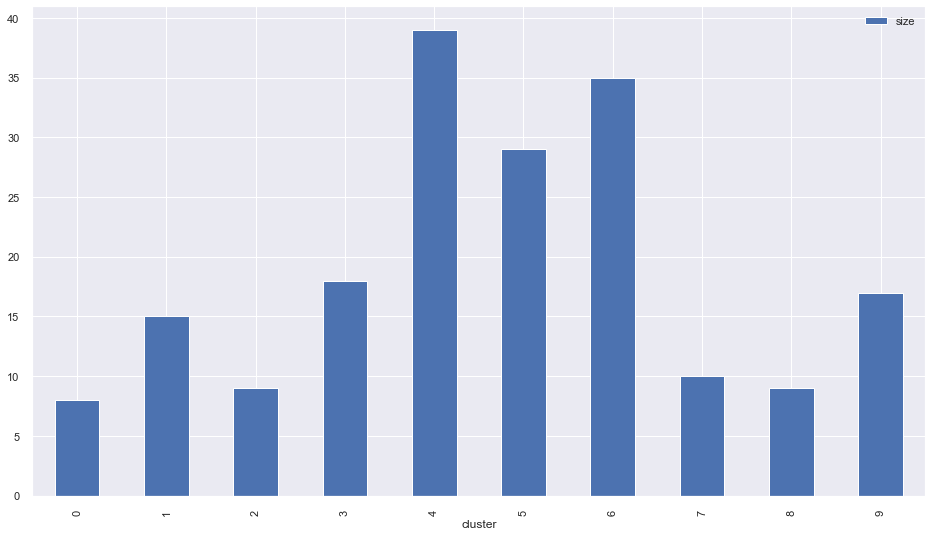

In [27]:
sizes = []
for i in range(10):
    sizes.append({"cluster": i, "size": np.sum(k_means_text.labels_==i)}) 
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))

## Wordclouds:

## WordClouds from the LDA model:

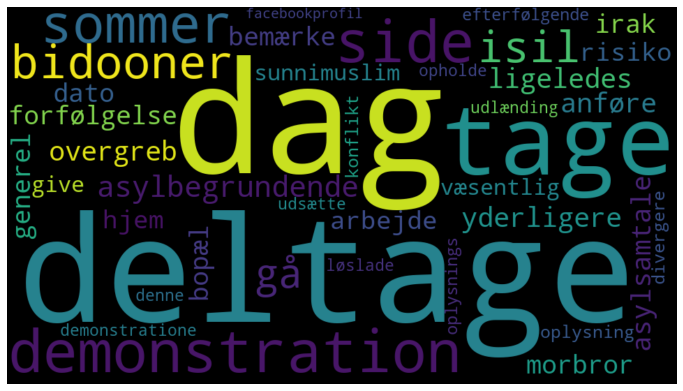

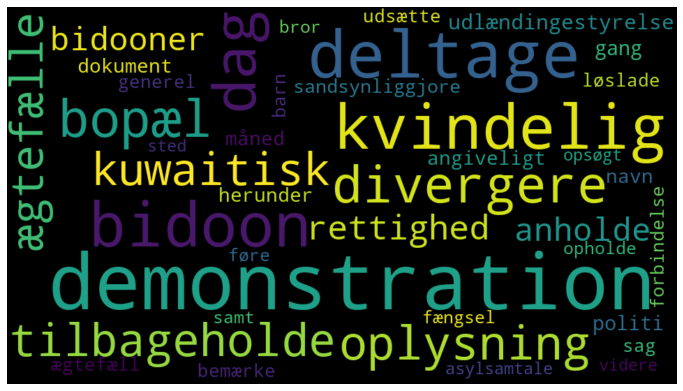

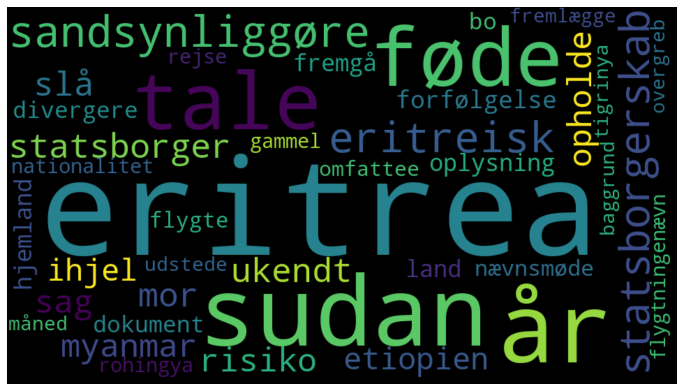

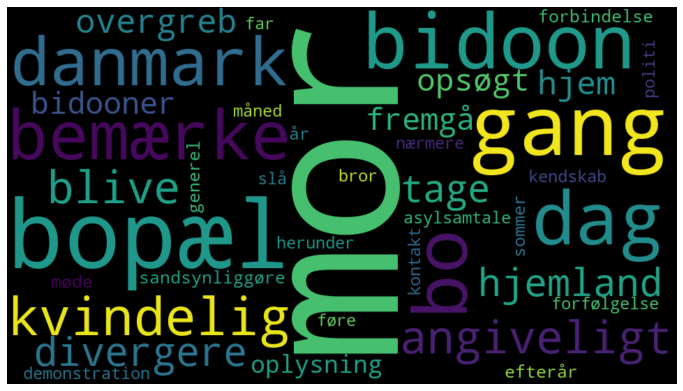

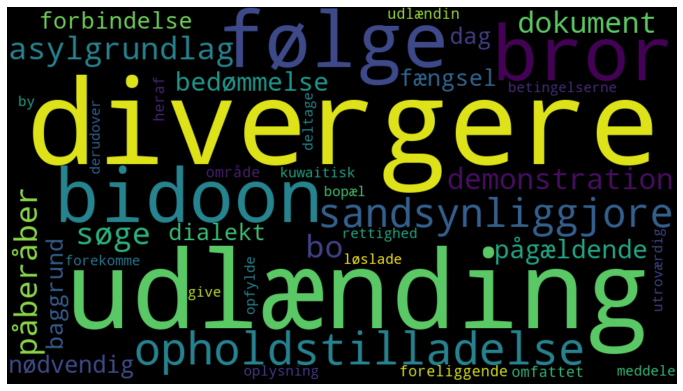

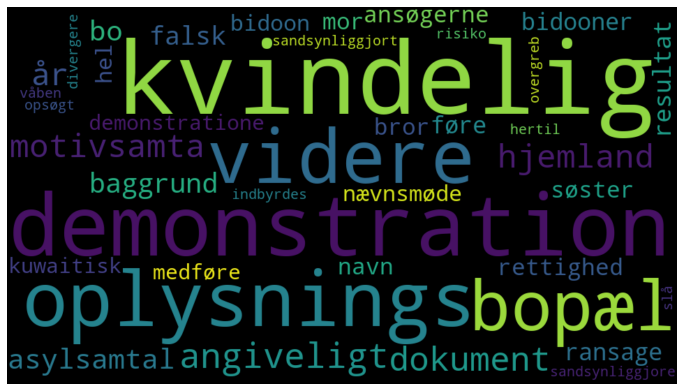

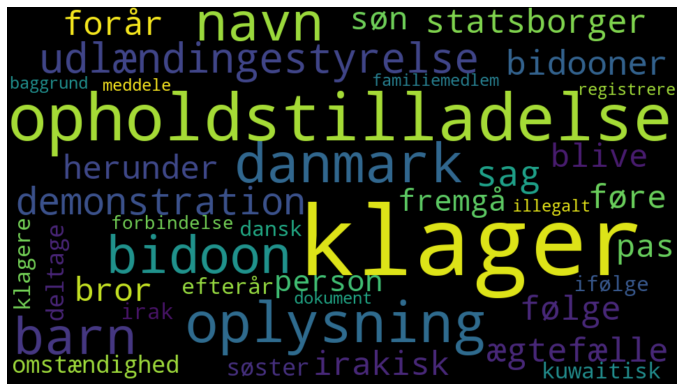

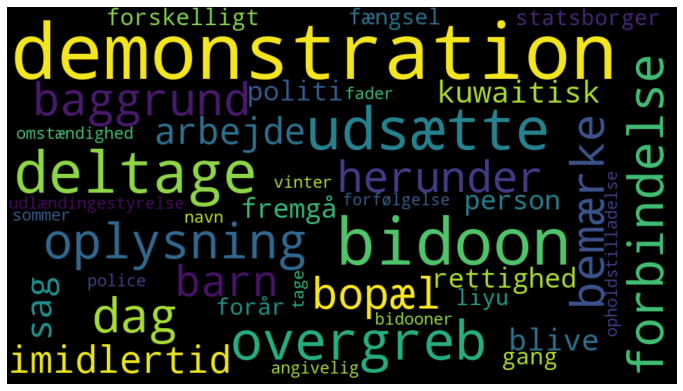

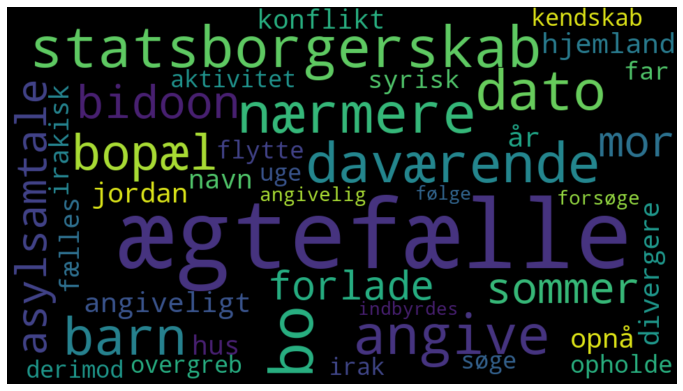

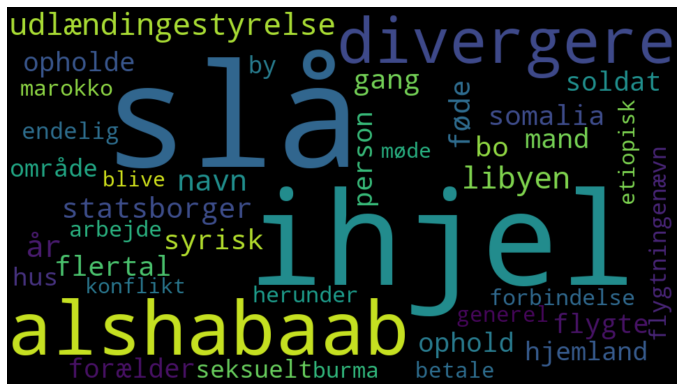

In [28]:
hp.wordcloud_topics(LDA_model, count_text_vectorizer.get_feature_names_out())

## WordClouds from the NMF model:

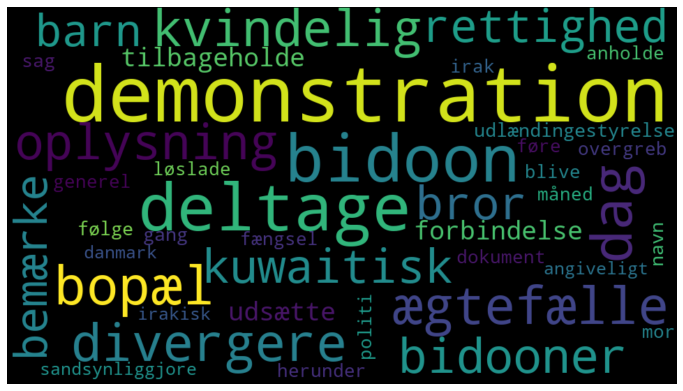

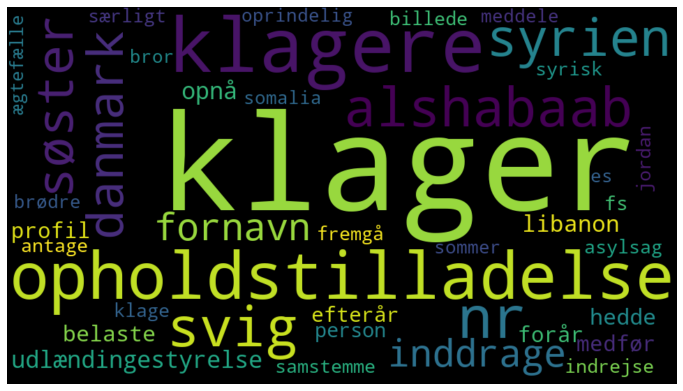

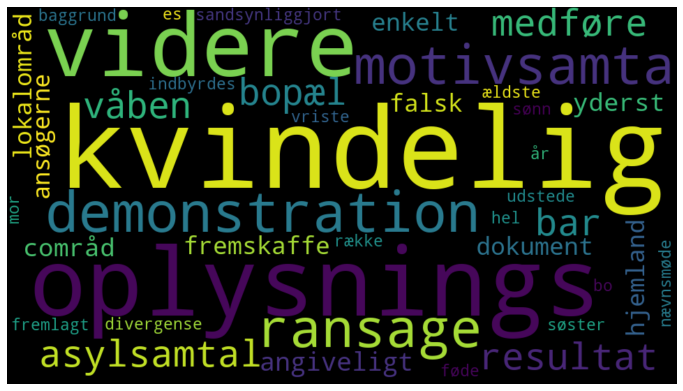

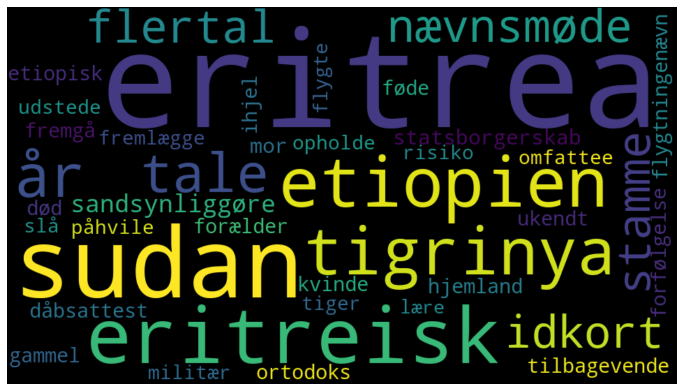

In [29]:
hp.wordcloud_topics(NMF_model, tfidf_text_vectorizer.get_feature_names_out())

## WordsClouds from the SVD model:

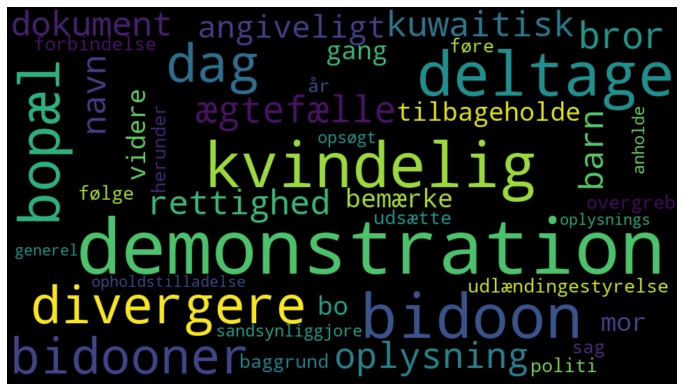

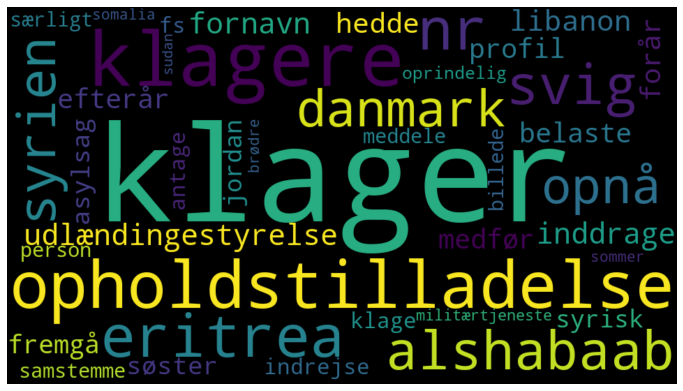

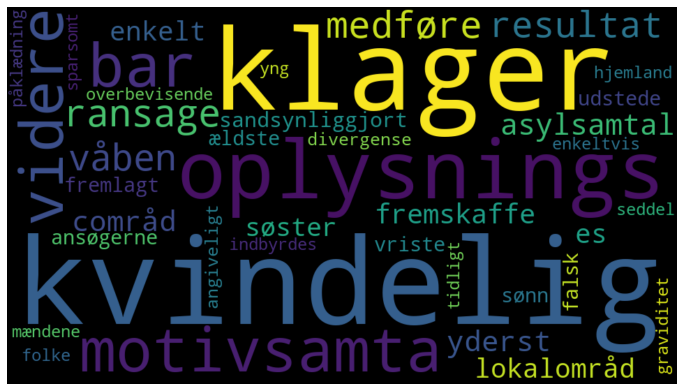

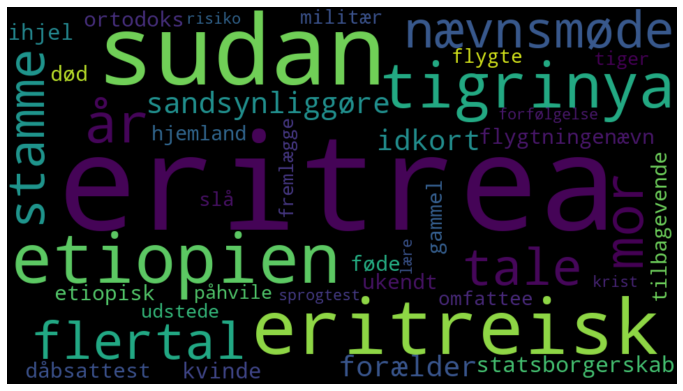

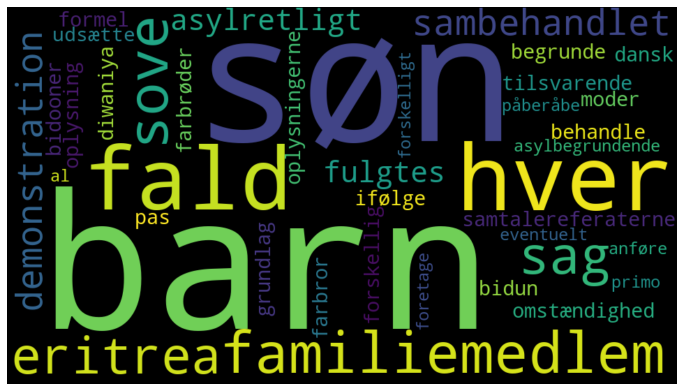

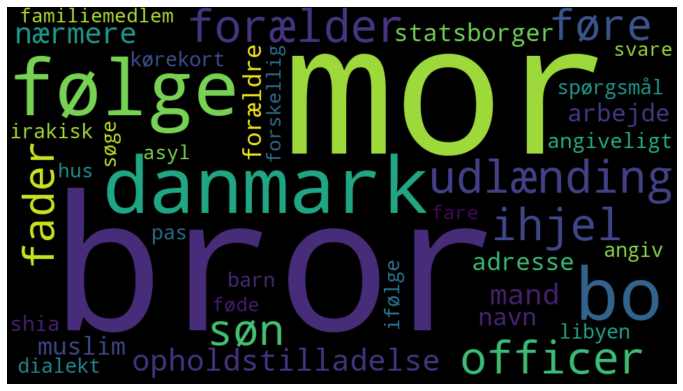

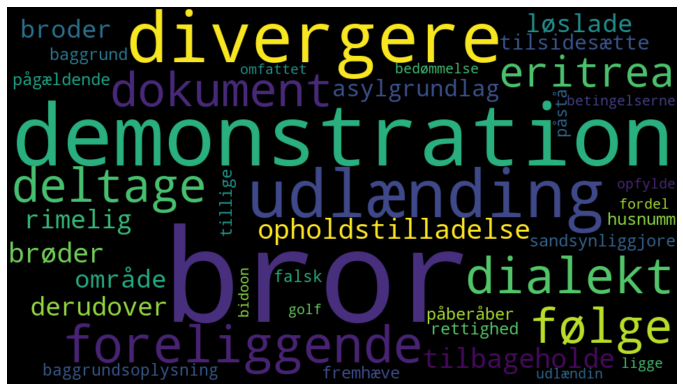

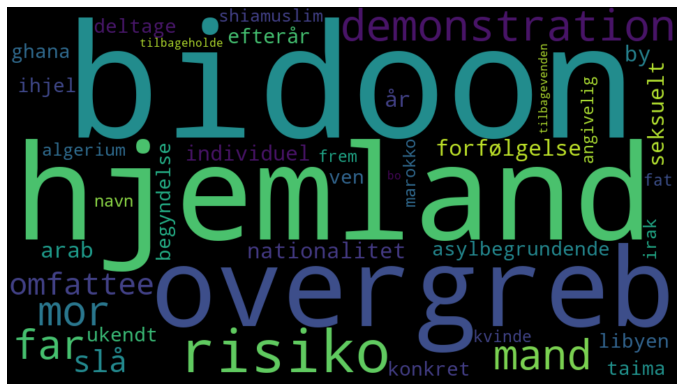

In [30]:
hp.wordcloud_topics(SVD_model, tfidf_text_vectorizer.get_feature_names_out())

## WordClouds from Kmeans clustering:

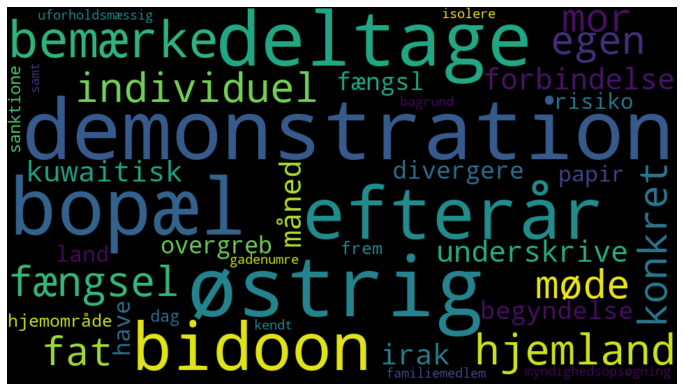

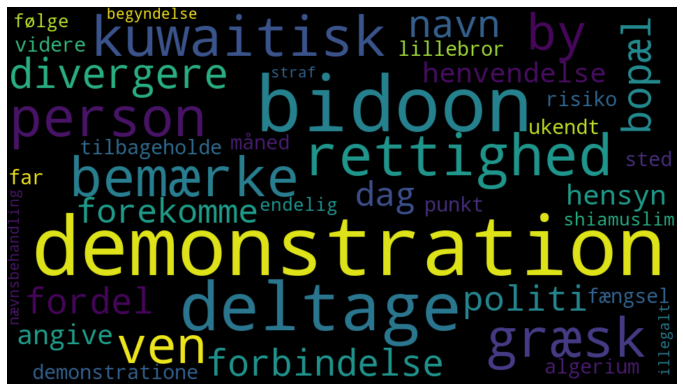

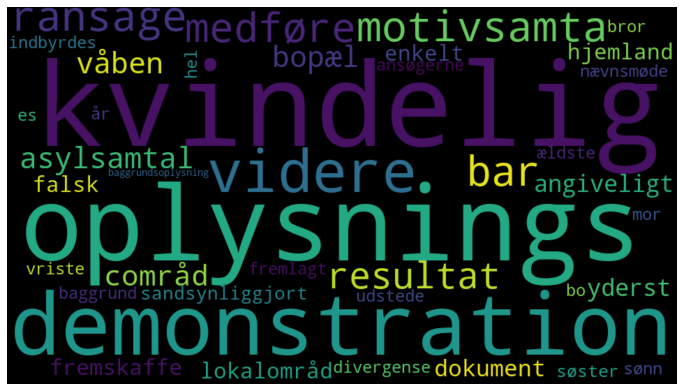

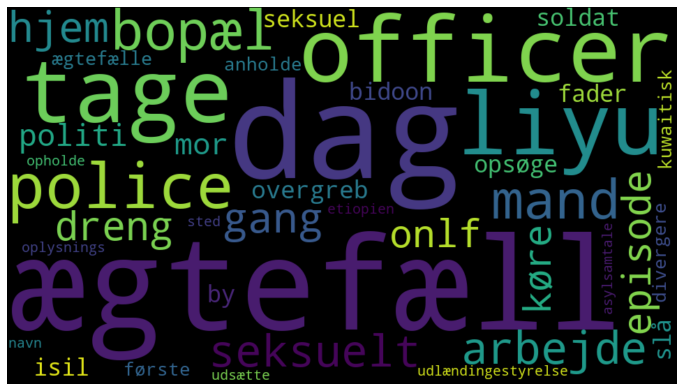

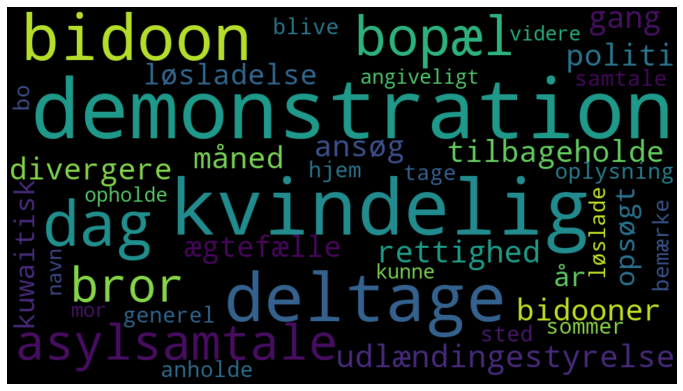

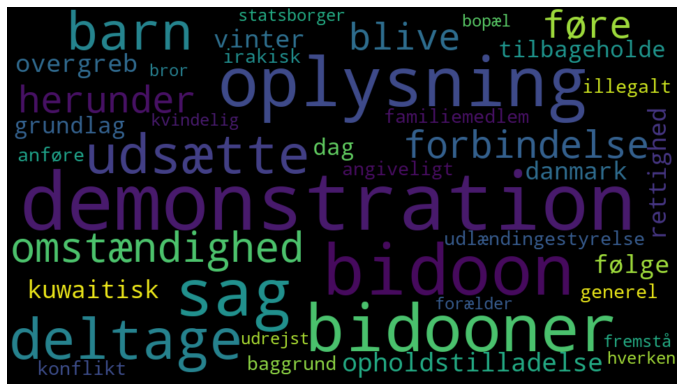

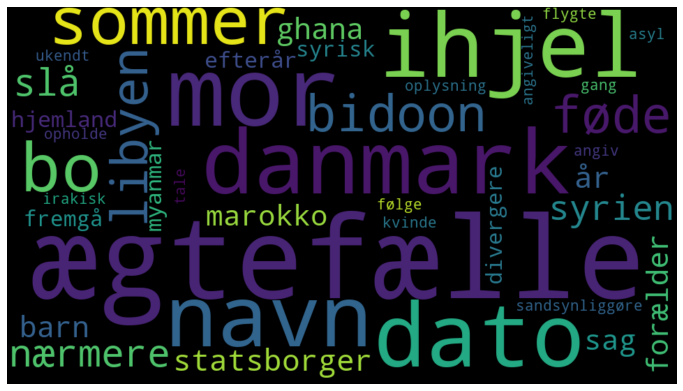

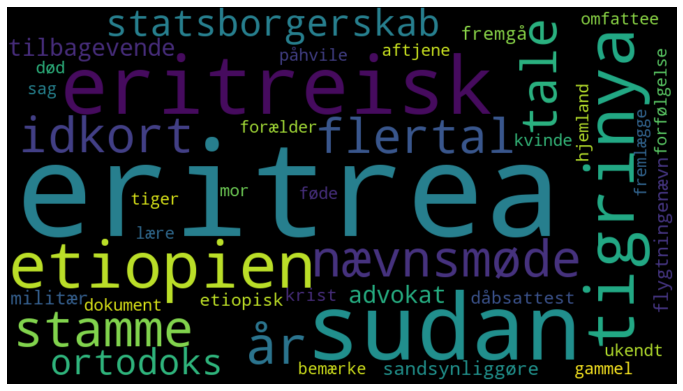

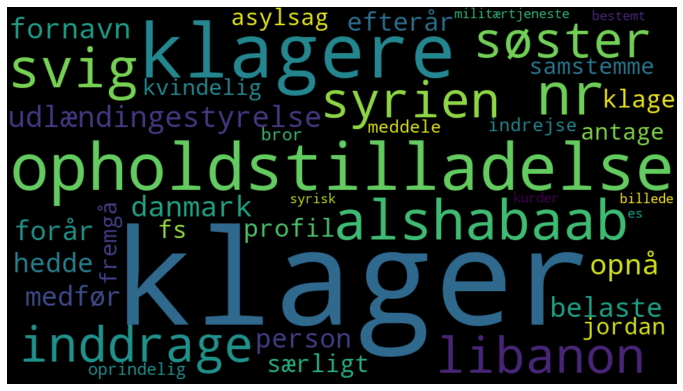

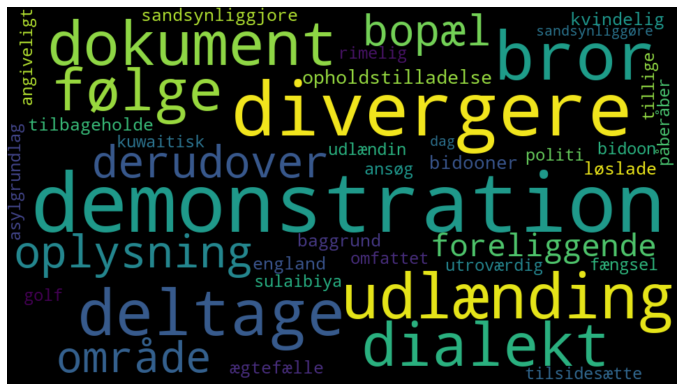

In [31]:
hp.wordcloud_clusters(k_means_text, tfidf_text_vectors, tfidf_text_vectorizer.get_feature_names_out())